In [30]:
# Reseteamos todas las variables del entorno
# %reset
# IMPORT LIBRARIES

# Processing
import librosa
import librosa.display
import numpy as np
import random
from tqdm import tqdm

# Visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import IPython.display as ipd

# Files
import os
import joblib
import pickle

# Machine Learning
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix
import keras
from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.layers import Conv2D, MaxPooling2D
import tensorflow as tf

# ####### TEST ####### 
# Scipy
from scipy import signal
from scipy.io import wavfile

# **CONFIGURACION DEL ENTORNO**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import sys  
GPATH = '/content/drive/My Drive/Master/Asignaturas/2 Cuatrimestre/Proyecto/Code/'

if GPATH + '/SpeechEmotionRecognition' in sys.path:
  sys.path.remove(GPATH + '/SpeechEmotionRecognition')

sys.path.insert(0, GPATH + '/SpeechEmotionRecognition')

sys.path

['/content/drive/My Drive/Master/Asignaturas/2 Cuatrimestre/Proyecto/Code//SpeechEmotionRecognition',
 '',
 '/content',
 '/env/python',
 '/usr/lib/python37.zip',
 '/usr/lib/python3.7',
 '/usr/lib/python3.7/lib-dynload',
 '/usr/local/lib/python3.7/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.7/dist-packages/IPython/extensions',
 '/root/.ipython']

In [4]:
FEATURES_PATH = GPATH + 'SpeechEmotionRecognition/data/processed/features/'
FIGURES_PATH = GPATH + 'SpeechEmotionRecognition/reports/figures/'
# Datasets
SAVEE_PATH = GPATH + 'data/SAVEE/'
TESS_PATH = GPATH + 'data/TESS/'
RAVDESS_PATH = GPATH + 'data/RAVDESS/'
EMODB_PATH = GPATH + 'data/EMODB/'

# Espectogramas
SPECT_IMG = GPATH + 'data/spectrograms/'
SPECTOGRAM_MODEL = SPECT_IMG + 'mfcc_savee_tess/test_german'

# Maps
EMOTION_MAP = {4:'neutral', 2:'happy', 3:'sad', 0:'angry', 1:'disgust'}
reduced_values = ['angry', 'disgust', 'happy', 'sad', 'neutral']

## **1. DATOS**

In [5]:
# Leemos EMO-DB
EMOTION_EMODB_MAP = {'F':'happy', 'T':'sad', 'W':'angry','E':'disgust', 'N':'neutral'}
emotion=[]
path = []

for filename in os.listdir(EMODB_PATH):
  str_path = EMODB_PATH +  '/' + str(filename)
  emo_capital = filename[5]
  if emo_capital in EMOTION_EMODB_MAP:
    emotion.append(EMOTION_EMODB_MAP[emo_capital])
    path.append(str_path)
  
EMODDB_df = pd.DataFrame(columns=['emotion', 'path'])
EMODDB_df['emotion'] = emotion
EMODDB_df['path'] = path

class_distribution = EMODDB_df['emotion'].value_counts()
print( class_distribution )

angry      127
neutral     79
happy       71
sad         62
disgust     46
Name: emotion, dtype: int64


In [6]:
print( class_distribution )

angry      127
neutral     79
happy       71
sad         62
disgust     46
Name: emotion, dtype: int64


In [7]:
# from src.SpeechDataProcess import SpeechDataProcess
# data = SpeechDataProcess('TESS', TESS_PATH)
# TESS_df = data.read()
# data = SpeechDataProcess('SAVEE', SAVEE_PATH)
# SAVEE_df = data.read()

In [8]:
emotion=[]
path = []
reduced_values = ['a', 'd', 'h', 'sa', 'n']

for dir in os.listdir(SAVEE_PATH):
  path_dir = os.listdir(SAVEE_PATH + dir) # todos los archivos de audios asociados a un directorio
  for filename in path_dir:
    str_path = SAVEE_PATH + dir + '/' + str(filename)
    label = filename[0]
    if filename[1].isalpha() : label = filename[0] + filename[1] 
    # Solo los valores reducidos
    if label in reduced_values:
      path.append(str_path)
      if(label=='a'):
          emotion.append("angry")
      elif(label=='h'):
          emotion.append("happy")
      elif(label=='f'):
          emotion.append("fear")
      elif(label=='d'):
          emotion.append("disgust")
      elif(label=='n'):
          emotion.append('neutral')
      elif(label=='sa'):
          emotion.append("sad")
      elif(label=='su'):
          emotion.append("surprise")


SAVEE_df = pd.DataFrame(columns=['emotion', 'path'])
SAVEE_df['emotion'] = emotion
SAVEE_df['path'] = path

SAVEE_df['emotion'].unique()
print( SAVEE_df['emotion'].value_counts() )

neutral    120
happy       60
angry       60
disgust     60
sad         60
Name: emotion, dtype: int64


In [9]:
# Leemos TESS

emotion=[]
path = []
reduced_values = ['angry', 'disgust', 'happy', 'sad', 'neutral']
for dir in os.listdir(TESS_PATH):
  path_dir = os.listdir(TESS_PATH + dir) # todos los archivos de audios asociados a un directorio
  label = dir.split('_')[1]
  for filename in path_dir:
    str_path = TESS_PATH + dir + '/' + str(filename)

    # Solo los valores reducidos
    if label.lower() in reduced_values:
      path.append(str_path)
      emotion.append(label.lower())


TESS_df = pd.DataFrame(columns=['emotion', 'path'])
TESS_df['emotion'] = emotion
TESS_df['path'] = path

print( "Size of the dataset: {} \n".format(len(TESS_df)) )
print( TESS_df['emotion'].value_counts() )
# TESS_df.sample(5)

Size of the dataset: 2000 

disgust    400
angry      400
neutral    400
sad        400
happy      400
Name: emotion, dtype: int64


In [10]:
if len(TESS_df.emotion.unique()) == len(SAVEE_df.emotion.unique()) and len(TESS_df.emotion.unique()) == len(EMODDB_df.emotion.unique()):
  print("Todas las dimensiones son correctas")

Todas las dimensiones son correctas


### **1.2 EXTRACCION DE ESPECTROGRAMAS**

In [11]:
from src.MFCC import MFCC

In [12]:
features_spectMFCC_SAVEE = MFCC(df_data = SAVEE_df, dataset_name = "SAVEE")
features_spectMFCC_TESS = MFCC(df_data = TESS_df, dataset_name = "TESS")

features_spectMFCC_EMODB = MFCC(df_data = EMODDB_df, dataset_name = "EMODB")
# list_images, labels = featuresMFCC_SAVEE.load_images(IMG_MFCC, (40,40))

In [13]:
# # Genero los espectrogramas
# features_spectMFCC_SAVEE.generate_spectrograms(SPECT_IMG)
# features_spectMFCC_TESS.generate_spectrograms(SPECT_IMG)

# # Genero los espectogramas de test
# features_spectMFCC_EMODB.generate_spectrograms(SPECT_IMG + 'test_emodb/')


In [14]:
list_images_savee_tess, labels = features_spectMFCC_TESS.load_spectograms_dataset(SPECTOGRAM_MODEL, (30,40))

Leídas 460 espectogramas pertenecientes a angry
Leídas 460 espectogramas pertenecientes a disgust
Leídas 460 espectogramas pertenecientes a happy
Leídas 524 espectogramas pertenecientes a neutral
Leídas 460 espectogramas pertenecientes a sad


In [15]:
array_images_savee_tess = np.array(list_images_savee_tess)
print("{} imagenes con dimension {}".format(array_images_savee_tess.shape[0], array_images_savee_tess.shape[1:]))

2364 imagenes con dimension (40, 30, 3)


In [17]:
list_images_emodb, labels_emodb = features_spectMFCC_EMODB.load_spectograms_dataset(SPECT_IMG + 'test_emodb/', (30,40))
array_images_emodb= np.array(list_images_emodb)

Leídas 400 espectogramas pertenecientes a sad
Leídas 400 espectogramas pertenecientes a happy
Leídas 400 espectogramas pertenecientes a neutral
Leídas 400 espectogramas pertenecientes a angry
Leídas 400 espectogramas pertenecientes a disgust


## **2. DEFINICION DEL MODELO**

In [24]:
def get_model_2D_CNN(shape, classes): # Ganador
  model=Sequential()
  model.add(Conv2D(32,(4,10),input_shape=shape, activation='relu',padding='same'))
  model.add(MaxPooling2D(3,3))
  model.add(Dropout(0.2))

  model.add(Conv2D(32,(4,10),activation='relu',padding='same'))
  model.add(MaxPooling2D(3,3))
  model.add(Dropout(0.2))

  model.add(Conv2D(32,(4,10),activation='relu',padding='same'))
  model.add(MaxPooling2D(3,3))
  model.add(Dropout(0.2))

  model.add(Flatten())
  model.add(Dense(classes, activation='softmax'))
 
  return model


def plot_loss_acc(history):
  # Mostramos la grafica loss 
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
  ax1.plot(history.history['loss'])
  ax1.plot(history.history['val_loss'])
  ax1.set_title('Loss')
  ax1.set(xlabel='epoch', ylabel='loss')
  ax1.legend(['train', 'test'], loc='upper right')

  # Mostramos la grafica accuracy
  ax2.plot(history.history['accuracy'])
  ax2.plot(history.history['val_accuracy'])
  ax2.set_title('Validation')
  ax2.set(xlabel='epoch', ylabel='acc')

  ax2.legend(['train', 'test'], loc='lower right')


def processData(data, labels, test_size = 0.25):
  X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=test_size, shuffle=True, random_state=42)

  # one hot encoding 
  lb = LabelEncoder()
  y_train = np_utils.to_categorical(lb.fit_transform(y_train))
  y_test = np_utils.to_categorical(lb.fit_transform(y_test))

  # Normalization as per the standard NN process
  mean = np.mean(X_train, axis=0)
  std = np.std(X_train, axis=0)

  X_train = (X_train - mean)/std
  X_test = (X_test - mean)/std

  return X_train, X_test, y_train, y_test

  

#### **2.1 ENTRENAMIENTO**

In [26]:
X_train, X_test, y_train, y_test = processData(array_images_savee_tess, labels)

In [27]:
print("Entrenamiento: Datos con dimension {}, y clases con {}".format(X_train.shape, y_train.shape))
print("Test: Datos con dimension {}, y clases con {}".format(X_test.shape, y_test.shape))

Entrenamiento: Datos con dimension (1773, 40, 30, 3), y clases con (1773, 5)
Test: Datos con dimension (591, 40, 30, 3), y clases con (591, 5)


In [47]:
modelA = get_model_2D_CNN(X_emo_train.shape[1:], y_emo_train.shape[1])
modelA.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 40, 30, 32)        3872      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 10, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 13, 10, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 10, 32)        40992     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 4, 3, 32)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 4, 3, 32)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 3, 32)         

In [48]:
modelA.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
historyA = modelA.fit(X_emo_train, y_emo_train, 
                      batch_size=32, 
                      epochs=100, 
                      validation_data=(X_emo_test, y_emo_test))

Epoch 1/100
44/44 [==============================] - 6s 110ms/step - loss: 1.5365 - accuracy: 0.3168 - val_loss: 1.1233 - val_accuracy: 0.5700
Epoch 2/100
44/44 [==============================] - 4s 99ms/step - loss: 1.1522 - accuracy: 0.5592 - val_loss: 0.4521 - val_accuracy: 0.8867
Epoch 3/100
44/44 [==============================] - 4s 100ms/step - loss: 0.5831 - accuracy: 0.8019 - val_loss: 0.1423 - val_accuracy: 0.9700
Epoch 4/100
44/44 [==============================] - 4s 100ms/step - loss: 0.2761 - accuracy: 0.9133 - val_loss: 0.0681 - val_accuracy: 0.9867
Epoch 5/100
44/44 [==============================] - 4s 99ms/step - loss: 0.1340 - accuracy: 0.9547 - val_loss: 0.1036 - val_accuracy: 0.9800
Epoch 6/100
44/44 [==============================] - 4s 100ms/step - loss: 0.1205 - accuracy: 0.9628 - val_loss: 0.0284 - val_accuracy: 0.9950
Epoch 7/100
44/44 [==============================] - 4s 100ms/step - loss: 0.0805 - accuracy: 0.9687 - val_loss: 0.0389 - val_accuracy: 0.9900
E

38/38 [==============================] - 1s 13ms/step - loss: 0.0124 - accuracy: 0.9950
Loss: 0.01241647731512785 
Accuracy: 99.50000047683716%


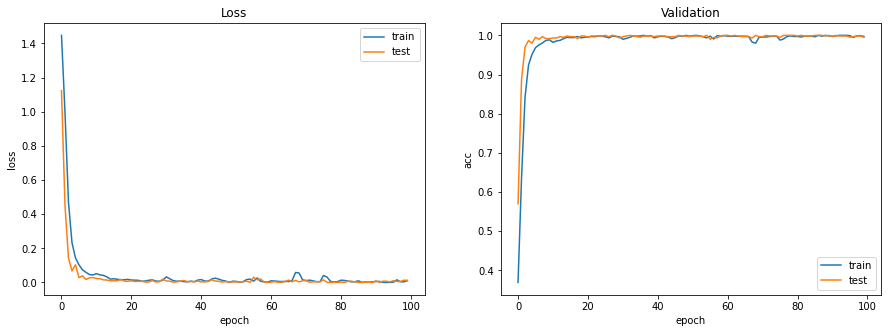

In [50]:
plot_loss_acc(historyA)
# Evaluamos contra test
score = modelA.evaluate(X_emo_test, y_emo_test, batch_size=16)
print("Loss: {} \nAccuracy: {}%".format(score[0], score[1]*100))

#### **2.2 EVALUACION**

In [43]:
X_emo_train, X_emo_test, y_emo_train, y_emo_test = processData(array_images_emodb, labels_emodb, 0.30)

In [44]:
print("Entrenamiento: Datos con dimension {}, y clases con {}".format(X_emo_train.shape, y_emo_train.shape))
print("Test: Datos con dimension {}, y clases con {}".format(X_emo_test.shape, y_emo_test.shape))

Entrenamiento: Datos con dimension (1400, 40, 30, 3), y clases con (1400, 5)
Test: Datos con dimension (600, 40, 30, 3), y clases con (600, 5)


In [51]:
from sklearn.metrics import classification_report

predicted_y = modelA.predict(X_train)
predicted_y = np.argmax(np.round(predicted_y),axis=1)

categorical_labels = np.argmax(y_train, axis=1)


# Mapeo el nombre de las clases
predicted_y = list(map(EMOTION_MAP.get, predicted_y))
categorical_labels = list(map(EMOTION_MAP.get, categorical_labels))

In [52]:
print(classification_report(categorical_labels, predicted_y))

              precision    recall  f1-score   support

       angry       0.01      0.01      0.01       333
     disgust       0.00      0.00      0.00       353
       happy       0.03      0.03      0.03       344
     neutral       0.03      0.04      0.04       356
         sad       0.00      0.00      0.00       387

    accuracy                           0.02      1773
   macro avg       0.01      0.02      0.02      1773
weighted avg       0.01      0.02      0.01      1773

